# **Data Exploration** #


This section focuses on preparing the dataset for analysis by standardizing text fields such as job descriptions and company names. Key preprocessing steps include text tokenization, normalization, and the creation of a feature to distinguish between AI-generated and real-world data. These steps will ensure the data is structured and ready for feature extraction and modeling.

In [507]:
import sqlite3
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rithika/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rithika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/rithika/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/rithika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Importing Data** ###

In [508]:
def getData():
    conn = sqlite3.connect('data/labelled_data.db')
    query = "SELECT * FROM  labelled_job_postings"
    df = pd.read_sql_query(query, conn)    
    conn.close()
    return df

In [509]:
df = getData()
df.head()

,id,job_posting_id,title,company,location,description,job_site,sponsorship_available
0,1,4038627932,PHP Developer,Odd Shoes,United Kingdom,"We all remember that favourite teacher from school.\nYou’re thinking of that teacher now, aren’t you? (Mine was Mrs Aspinall)\nThey connected with you, respected you and gave you the confidence to...",LinkedIn,Sponsorship Not Provided
1,2,4041491685,PHP Developer,Better Placed Ltd - A Sunday Times Top 10 Employer in 2023!,United Kingdom,"PHP / Laravel Developer \nFull Remote Working (Must be UK based / no sponsorship available.)Unlimited Holidays\n £45,000- £55,000\nThe business is part of a 220m revenue group, but operates indepe...",LinkedIn,Sponsorship Not Provided
2,3,4039079429,Python Software Engineer,CFC,"London Area, United Kingdom","Job Description: \nWorking within the specialist Underwriting Data Services team at CFC, your role will be in developing our proprietary data collection platform, solving data problems that are ke...",LinkedIn,Uncertain
3,4,4039504748,Full Stack Engineer,Two Circles,"London, England, United Kingdom","ROLE: Full Stack EngineerOFFICE: LondonAbout Us: Two Circles is a global sports agency. We drive growth for sports properties by delivering deeper connections with fans, through the intelligent us...",LinkedIn,Uncertain
4,5,4040799491,C++ Software Engineer,KO2 Embedded Recruitment Solutions Ltd,"Reading, England, United Kingdom","Position: C++ Linux Software Engineer\n\nLocation of work: Fully remote working - you should be UK based\n\n\nSalary: up to £70,000 + Benefits\n\nThe Role\n\nKO2's client is a leading IoT business...",LinkedIn,Sponsorship Not Provided


In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3000 non-null   int64 
 1   job_posting_id         1000 non-null   object
 2   title                  3000 non-null   object
 3   company                3000 non-null   object
 4   location               3000 non-null   object
 5   description            3000 non-null   object
 6   job_site               1000 non-null   object
 7   sponsorship_available  3000 non-null   object
dtypes: int64(1), object(7)
memory usage: 187.6+ KB


Out of the 3,000 records in the dataset, 1,000 have null values for the job posting ID and job site fields. These records were initially sourced from LinkedIn and manually labeled. However, upon analysis, it was observed that the categories were unevenly distributed. To address this imbalance, 2,000 additional records were generated using AI Gretel, ensuring an equal distribution across all categories. 

 A new column, is_ai_generated, will be added to distinguish between real and AI-generated records. This will help in analyzing the differences in data patterns, identifying potential biases, and ensuring the synthetic data aligns well with real-world trends.

In [511]:
df['is_ai_generated'] = df['job_posting_id'].isnull() & df['job_site'].isnull()
df['is_ai_generated'] = df['is_ai_generated'].astype(int)
df.head()


,id,job_posting_id,title,company,location,description,job_site,sponsorship_available,is_ai_generated
0,1,4038627932,PHP Developer,Odd Shoes,United Kingdom,"We all remember that favourite teacher from school.\nYou’re thinking of that teacher now, aren’t you? (Mine was Mrs Aspinall)\nThey connected with you, respected you and gave you the confidence to...",LinkedIn,Sponsorship Not Provided,0
1,2,4041491685,PHP Developer,Better Placed Ltd - A Sunday Times Top 10 Employer in 2023!,United Kingdom,"PHP / Laravel Developer \nFull Remote Working (Must be UK based / no sponsorship available.)Unlimited Holidays\n £45,000- £55,000\nThe business is part of a 220m revenue group, but operates indepe...",LinkedIn,Sponsorship Not Provided,0
2,3,4039079429,Python Software Engineer,CFC,"London Area, United Kingdom","Job Description: \nWorking within the specialist Underwriting Data Services team at CFC, your role will be in developing our proprietary data collection platform, solving data problems that are ke...",LinkedIn,Uncertain,0
3,4,4039504748,Full Stack Engineer,Two Circles,"London, England, United Kingdom","ROLE: Full Stack EngineerOFFICE: LondonAbout Us: Two Circles is a global sports agency. We drive growth for sports properties by delivering deeper connections with fans, through the intelligent us...",LinkedIn,Uncertain,0
4,5,4040799491,C++ Software Engineer,KO2 Embedded Recruitment Solutions Ltd,"Reading, England, United Kingdom","Position: C++ Linux Software Engineer\n\nLocation of work: Fully remote working - you should be UK based\n\n\nSalary: up to £70,000 + Benefits\n\nThe Role\n\nKO2's client is a leading IoT business...",LinkedIn,Sponsorship Not Provided,0


In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3000 non-null   int64 
 1   job_posting_id         1000 non-null   object
 2   title                  3000 non-null   object
 3   company                3000 non-null   object
 4   location               3000 non-null   object
 5   description            3000 non-null   object
 6   job_site               1000 non-null   object
 7   sponsorship_available  3000 non-null   object
 8   is_ai_generated        3000 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 211.1+ KB


### **Fixing Data Types** ###

In [513]:
df['job_posting_id'] = df['job_posting_id'].astype('Int64')  # Convert job id from string type to int
df['sponsorship_available'] = df['sponsorship_available'].astype('category') # Convert sponsorship_available to category
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     3000 non-null   int64   
 1   job_posting_id         1000 non-null   Int64   
 2   title                  3000 non-null   object  
 3   company                3000 non-null   object  
 4   location               3000 non-null   object  
 5   description            3000 non-null   object  
 6   job_site               1000 non-null   object  
 7   sponsorship_available  3000 non-null   category
 8   is_ai_generated        3000 non-null   int64   
dtypes: Int64(1), category(1), int64(2), object(5)
memory usage: 193.6+ KB


The records with null values in the job_posting_id and job_site fields are retained as they correspond to AI-generated data. It is assumed that these missing values will have minimal impact on the training and modeling processes.

### **Data Labelling and Imbalance** ###

Initially, 1,000 records were collected from LinkedIn using the LinkedIn API and were manually labeled using a custom-built program. The records were categorized into three distinct categories:

Uncertain: No mention of sponsorship is made in the job posting.
Sponsorship Not Provided: The job posting explicitly states that sponsorship will not be provided.
Sponsorship Provided: The job posting explicitly states that sponsorship will be provided.
However, upon analysis, it was observed that the data was significantly imbalanced across these categories, as shown below:

In [514]:
df[df['is_ai_generated']==0]['sponsorship_available'].value_counts()

sponsorship_available
Uncertain                   796
Sponsorship Not Provided    192
Sponsorship Provided         12
Name: count, dtype: int64

To address the imbalance, additional data was required. To save time and resources on manual labeling, an AI data generator was utilized to produce synthetic job postings that addressed the imbalance. After incorporating the AI-generated data, the categories are now equally balanced:

In [515]:
df['sponsorship_available'].value_counts()

sponsorship_available
Sponsorship Not Provided    1000
Sponsorship Provided        1000
Uncertain                   1000
Name: count, dtype: int64

### **Initial Data Exploration** ###

The Initial Data Exploration stage will focus on gaining a high-level understanding of the dataset. Key activities will include analyzing word counts, identifying frequently used words, and examining text length distributions. This step will help uncover patterns, detect potential stopwords, and highlight anomalies or trends in the raw text before applying any preprocessing. By performing this exploration, a clear direction will be established for subsequent cleaning and transformation stages.

The aim of this section is to analyze the overall distribution of text lengths in job descriptions across three datasets: real data, artificially generated data, and their combined version. It will seek to compare the variability, range, and overall patterns in text lengths between these datasets to understand how they will differ and interact when merged.

#### 1. Disribution of Text Lengths across different Data Types ####

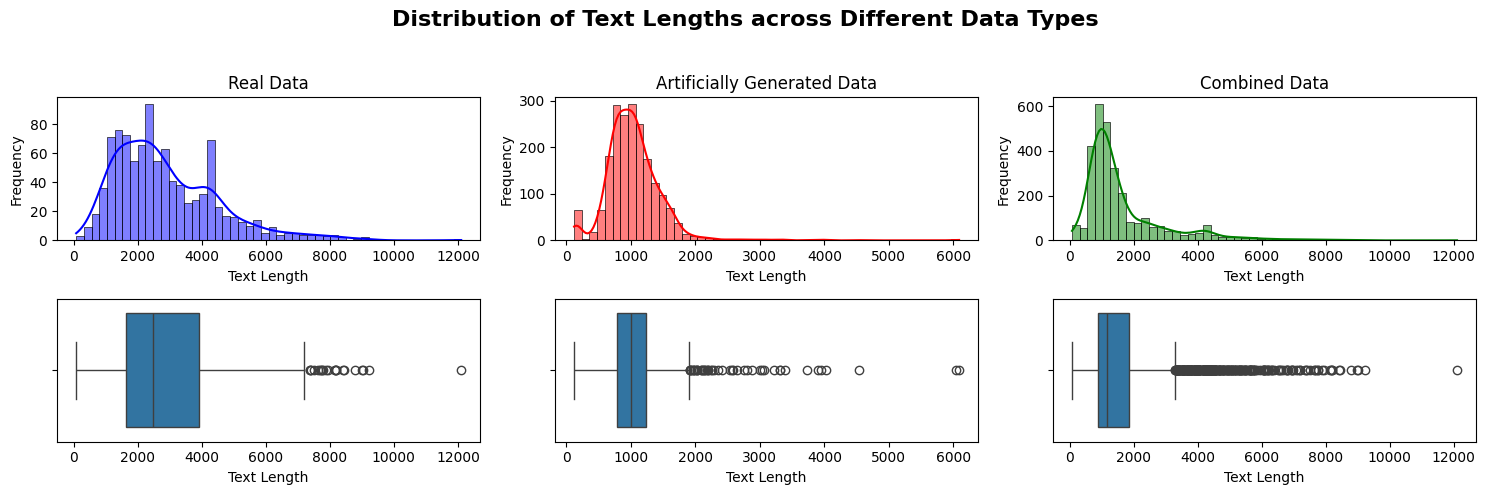

,Real Data,AI Generated Data,Combined Data
count,1000.00000,2000.000000,3000.000000
mean,2874.62200,1045.887500,1655.465667
std,1633.33625,444.914603,1328.168772
min,73.00000,123.000000,73.000000
25%,1629.00000,789.750000,875.000000
50%,2476.00000,1001.000000,1169.000000
75%,3911.00000,1234.500000,1845.000000
max,12104.00000,6088.000000,12104.000000


In [516]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=False)

sns.histplot(df[df['is_ai_generated']==False]['description'].str.len(), bins=50, kde=True, ax=axes[0][0], color='blue')
axes[0][0].set_title('Real Data')
axes[0][0].set_xlabel('Text Length')
axes[0][0].set_ylabel('Frequency')

sns.histplot(df[df['is_ai_generated']==True]['description'].str.len(), bins=50, kde=True, ax=axes[0][1], color='red')
axes[0][1].set_title('Artificially Generated Data')
axes[0][1].set_xlabel('Text Length')
axes[0][1].set_ylabel('Frequency')

sns.histplot(df['description'].str.len(), bins=50, kde=True, ax=axes[0][2], color='green')
axes[0][2].set_title('Combined Data')
axes[0][2].set_xlabel('Text Length')
axes[0][2].set_ylabel('Frequency')

sns.boxplot(x=df[df['is_ai_generated']==False]['description'].str.len(), ax=axes[1][0])
axes[1][0].set_xlabel('Text Length')

sns.boxplot(x=df[df['is_ai_generated']==True]['description'].str.len(), ax=axes[1][1])
axes[1][1].set_xlabel('Text Length')

sns.boxplot(x=df['description'].str.len(), ax=axes[1][2])
axes[1][2].set_xlabel('Text Length')


fig.suptitle('Distribution of Text Lengths across Different Data Types', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

text_length_stats = pd.DataFrame({"Real Data": df[df['is_ai_generated']==False]['description'].str.len().describe(),
                                  "AI Generated Data": df[df['is_ai_generated']==True]['description'].str.len().describe(),
                                  "Combined Data": df['description'].str.len().describe()})
text_length_stats

Looking at the chart provided, the real data's histogram reveals a skewed distribution with a peak around 2000-3000 characters and a long tail extending up to 12000 characters. This is corroborated by the table, which shows a high mean (2874.622) and a wide standard deviation (1633.336), indicating significant variability. The quartile values confirm that text lengths in real data are generally spread out, with a median of 2476 characters and many outliers extending up to 12104 characters.

In contrast, the AI-generated data shows a much narrower distribution, peaking around 1000 characters and tapering off by 6000 characters, which aligns with the table's mean of 1045.887 and lower standard deviation of 444.914. This suggests that AI-generated texts are more consistent in length. The combined data integrates both real and AI-generated texts, reflected in a combined distribution that resembles the real data but with more frequent shorter texts. The combined data table shows a mean of 1655.466 and a standard deviation of 1328.168, indicating a middle ground between the real and AI-generated data sets.

#### 2. Distribution of Text Lengths across Different Sponsorship Categories ####

This section aims to investigate how text lengths in job descriptions vary across different sponsorship categories: sponsorship not provided, sponsorship provided, and uncertain sponsorship. It seeks to identify patterns in text lengths within each category to understand how sponsorship status might relate to the structure and content of job postings.

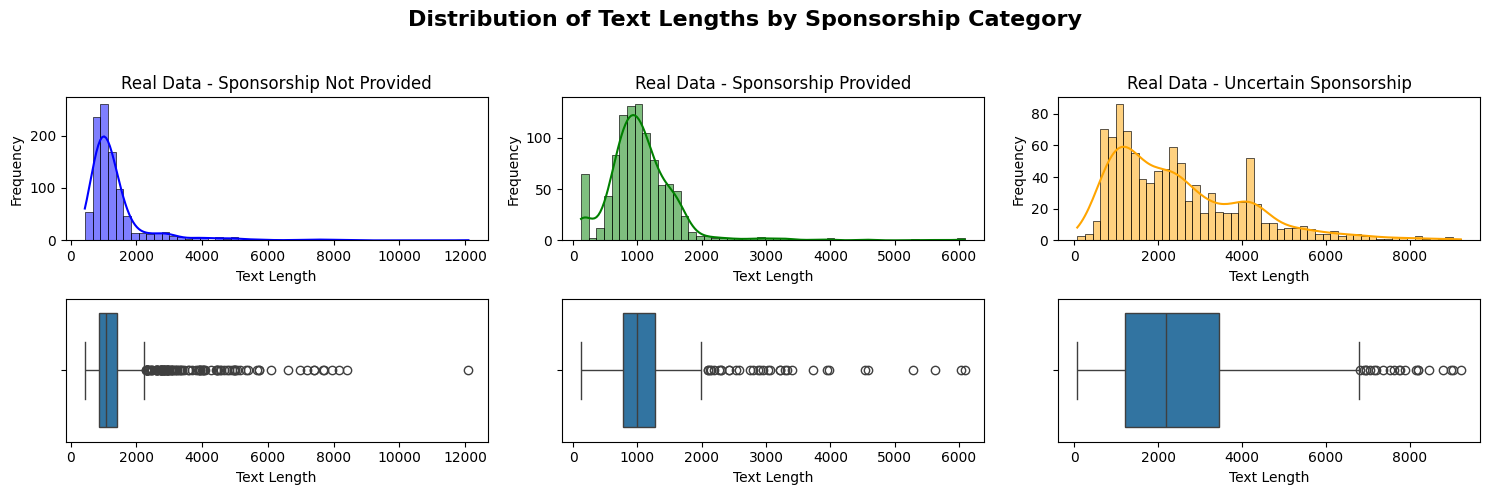

,Sponsorship Not Provided,Sponsorship Provided,Uncertain Sponsorship
count,1000.00000,1000.000000,1000.000000
mean,1396.76300,1066.538000,2503.096000
std,1091.94313,595.515632,1617.181612
min,430.00000,123.000000,73.000000
25%,853.75000,769.000000,1212.750000
50%,1089.00000,994.500000,2177.500000
75%,1411.00000,1276.750000,3452.750000
max,12104.00000,6088.000000,9218.000000


In [517]:
fig1, axes1 = plt.subplots(2, 3, figsize=(15, 5), sharey=False)

sns.histplot(df[df['sponsorship_available'] == 'Sponsorship Not Provided']['description'].str.len(), bins=50, kde=True, ax=axes1[0][0], color='blue')
axes1[0][0].set_title('Real Data - Sponsorship Not Provided')
axes1[0][0].set_xlabel('Text Length')
axes1[0][0].set_ylabel('Frequency')

sns.histplot(df[df['sponsorship_available'] == 'Sponsorship Provided']['description'].str.len(), bins=50, kde=True, ax=axes1[0][1], color='green')
axes1[0][1].set_title('Real Data - Sponsorship Provided')
axes1[0][1].set_xlabel('Text Length')
axes1[0][1].set_ylabel('Frequency')

sns.histplot(df[df['sponsorship_available'] == 'Uncertain']['description'].str.len(), bins=50, kde=True, ax=axes1[0][2], color='orange')
axes1[0][2].set_title('Real Data - Uncertain Sponsorship')
axes1[0][2].set_xlabel('Text Length')
axes1[0][2].set_ylabel('Frequency')


sns.boxplot(x=df[df['sponsorship_available']=='Sponsorship Not Provided']['description'].str.len(), ax=axes1[1][0])
axes1[1][0].set_xlabel('Text Length')

sns.boxplot(x=df[df['sponsorship_available']=='Sponsorship Provided']['description'].str.len(), ax=axes1[1][1])
axes1[1][1].set_xlabel('Text Length')

sns.boxplot(x=df[df['sponsorship_available']=='Uncertain']['description'].str.len(), ax=axes1[1][2])
axes1[1][2].set_xlabel('Text Length')


fig1.suptitle('Distribution of Text Lengths by Sponsorship Category', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

text_length_stats = pd.DataFrame({
    "Sponsorship Not Provided": df[(df['sponsorship_available'] == 'Sponsorship Not Provided')]['description'].str.len().describe(),
    "Sponsorship Provided": df[(df['sponsorship_available'] == 'Sponsorship Provided')]['description'].str.len().describe(),
    "Uncertain Sponsorship": df[(df['sponsorship_available'] == 'Uncertain')]['description'].str.len().describe()
})

text_length_stats


The "Sponsorship Not Provided" category shows a peak around 1000 characters with a long tail, and the table indicates a mean of 1396.763 and a standard deviation of 1091.943, highlighting moderate variability and some long texts. The "Sponsorship Provided" category has a higher peak at around 1000 characters, with the table showing a lower mean of 1066.538 and a smaller standard deviation of 595.516, indicating more consistent text lengths. The "Uncertain Sponsorship" category displays the most varied distribution, with multiple peaks, and the table confirms this with the highest mean (2503.096) and a large standard deviation (1617.186). The interquartile range spans from 1212.5 to 3452.75 characters, indicating significant diversity in text lengths for uncertain sponsorship cases.


#### 3. Frequency of words in the Job Descriptions ####

This section will explore the distribution of word frequencies in job descriptions, focusing on the most common terms used across different texts. A word cloud will be generated that will visually represent the prominence of specific words, with larger words indicating higher frequency. Additionally, a bar chart will be generated to provide a precise comparison of the top 10 most frequent words. This analysis will help identify key terms that frequently appear in job postings and highlight patterns or trends in the language used across the dataset.

In [518]:
def get_scaled_position_for_box_in_wordcloud(wordcloud, plt, word_position, fontsize, orientation, word):
    wordcloud_width, wordcloud_height = wordcloud.width, wordcloud.height
    ax_width, ax_height = plt[0].get_xlim()[1], plt[0].get_ylim()[0]
    
    x_scale, y_scale = ax_width/wordcloud_width, abs(ax_height/wordcloud_height)
    
    rect_x, rect_y = word_position[0] * x_scale, (max(0, word_position[1]-5) * y_scale)
    rect_width, rect_height = fontsize*len(word)*0.6, 5+(0.75*fontsize)

    return rect_x, rect_y, rect_width, rect_height

In [ ]:
def visualize_words(words, title):
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

    tokens = words.apply(word_tokenize)
    all_tokens = [word for token in tokens for word in token]
    word_freq = Counter(all_tokens)

    wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1).generate_from_frequencies(word_freq)
    axes2[0].imshow(wordcloud, interpolation='bilinear')
    axes2[0].axis('off')
    axes2[0].set_title('Word Cloud of Job Descriptions')
    
    keywordsRelatedToSponsorship = ["sponsorship", "visa", "right", "work", "h1b", "h-1b", "authorized", "authorization", "sponsor", "sponsored", "based", "security clearance", "passport", "eligible", "package", "offer"]

    for word, font_size, (y, x),  orientation, color in wordcloud.layout_:
        if word[0] in keywordsRelatedToSponsorship:
            # Draw a rectangle around the word
            rect_x, rect_y, rect_width, rect_height = get_scaled_position_for_box_in_wordcloud(wordcloud, axes2, (x, y), font_size, orientation, word[0])

            axes2[0].add_patch(plt.Rectangle(
                (rect_x, rect_y), rect_width, rect_height,  # Adjust width and height
                edgecolor='red', facecolor='none', lw=1  # Styling
            ))


    top_words = word_freq.most_common(20)
    top_words_df = pd.DataFrame(top_words, columns=['word', 'frequency'])
    sns.barplot(data=top_words_df, x='frequency', y='word',  ax = axes2[1])
    axes2[1].set_xlabel('Frequency')
    axes2[1].set_ylabel('Words')
    axes2[1].set_title('Top 20 Most Common Words')

    fig2.suptitle(title, fontsize=16, fontweight='bold')

plt.show()

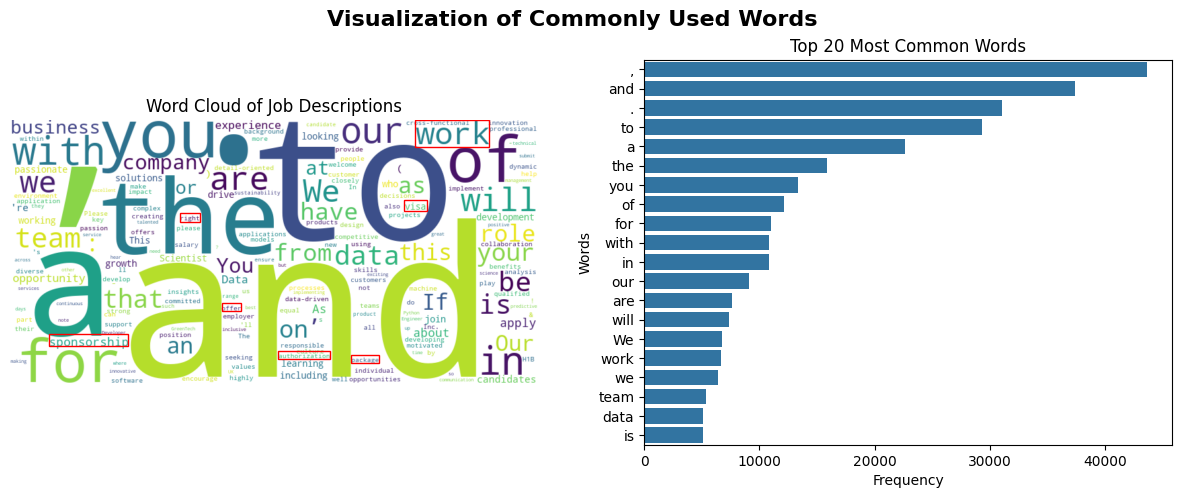

In [520]:
visualize_words(df['description'], 'Visualization of Commonly Used Words')

The top 10 most frequent words in the job descriptions predominantly consist of common stopwords and punctuation marks, such as commas, conjunctions, and prepositions. These words are often part of the structural framework of sentences rather than providing specific content. The frequent appearance of these terms suggests that the dataset contains a substantial amount of functional words that help form the grammatical structure of the descriptions, but they do not contribute significantly to understanding the core content of the job postings. These results highlight the need to filter out stopwords for more meaningful analysis of the actual job-related terms. The highlighted terms (in a red box) are keywords related sponsorship. The sizes of them are relatively smaller compared to the stop words.

### **Data Cleaning** ###

In [521]:
print("First 10 descriptions")
pd.set_option('display.max_colwidth', 200)
print(df['description'].head(10))

First 10 descriptions
0    We all remember that favourite teacher from school.\nYou’re thinking of that teacher now, aren’t you? (Mine was Mrs Aspinall)\nThey connected with you, respected you and gave you the confidence to...
1    PHP / Laravel Developer \nFull Remote Working (Must be UK based / no sponsorship available.)Unlimited Holidays\n £45,000- £55,000\nThe business is part of a 220m revenue group, but operates indepe...
2    Job Description: \nWorking within the specialist Underwriting Data Services team at CFC, your role will be in developing our proprietary data collection platform, solving data problems that are ke...
3    ROLE: Full Stack EngineerOFFICE: LondonAbout Us: Two Circles is a global sports agency. We drive growth for sports properties by delivering deeper connections with fans, through the intelligent us...
4    Position: C++ Linux Software Engineer\n\nLocation of work: Fully remote working - you should be UK based\n\n\nSalary: up to £70,000 + Benefits\n\nThe Rol

In [522]:
all_text = ''.join(df['description'].astype(str))
unique_characters = set(all_text)
print(f"Unique Characters:  {unique_characters}")

special_characters = "@#$%^*()_+-=<>/|\\[]{}~"
special_characters_found = []
for char in special_characters:
    if char in all_text:
        special_characters_found.append(char)
print(f"Special Characters: {special_characters_found}")

whitespace_issues = df['description'].str.contains(r'\s{2,}|\t|\n', regex=True).sum()
print(f"Rows with whitespace issues: {whitespace_issues}")

Unique Characters:  {':', 'r', '📚', ';', '🍕', '🍼', '🚀', '👶', '🏠', '.', 'C', '👉', '🏽', '[', '5', 'l', 'R', '\n', '🕹', '=', '📦', 'd', '`', '💪', '💡', '❓', '—', 'f', '🍏', 'à', 'ł', '🏖', '°', '💗', '<', '%', '🐶', 'i', '🏢', "'", 'p', '🌹', '$', 'J', '*', 'P', '@', '+', '👯', '́', '1', '🩹', '❄', '💌', '😍', '💛', '🖤', '|', '🎨', '☀', 'I', '"', '🏝', '🏡', '👋', '🤒', '™', 'ê', 'b', '🏻', '💭', '💕', 'S', '🎯', '⚙', 'Q', 'G', 'L', 'K', '🏬', '🍜', '🐛', '/', 'œ', 'q', '\x92', '{', 'c', '🚲', '🍝', '💻', '®', '🛑', 'ü', '\uf0a7', '!', '8', 'F', 'o', '©', '⚕', '👨', 't', '💸', '🎗', 'm', '🍎', 'W', '_', '👼', '3', '😎', 'O', '🛍', '●', '🐾', '>', '–', '📝', '📍', '“', '(', '2', '📢', '´', '🎉', '🙂', '🔍', '💼', '📩', '🛐', '🎁', 'Y', 'A', '🎓', 'N', '💷', 's', '📖', '🏥', '0', '🌱', '🤓', '🩺', '➕', '🕐', '🧡', '💯', '\u2000', '🏋', '✨', '\u202f', '⭐', 'e', '🌴', '’', '📱', 'D', 'h', 'V', '”', '🌟', '7', '🙌', 'w', '💃', '📋', ' ', '🧳', '£', 'º', '4', '✅', 'U', ')', 'H', '\ufeff', '·', 'E', 'u', 'z', '€', '🌈', '🧑', '🫶', 'x', '\u200d', 'k', 'v', '👀', 

It is noticed that the descriptions contain newline characters, excessive empty spaces, and special characters, including emojis. These elements can introduce noise into the data, making it harder to analyze and process effectively. Standardizing the text by removing these unnecessary elements is essential to ensure that the data is clean, consistent, and suitable for further analysis and modeling. By eliminating newline characters, the text becomes more structured and easier to tokenize. Removing extra spaces ensures uniformity, which helps in aligning the data for machine learning models. Special characters, including emojis, often do not contribute meaningful information to the task at hand and can inflate the vocabulary size unnecessarily, leading to inefficiencies. 

In [523]:
def clean_text(text):
    # Emoji regex pattern
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]+",
        flags=re.UNICODE,
    )

    # Remove emojis
    text = emoji_pattern.sub(r"", text)

    # Remove special characters and extra spaces, and preserve ?,.,!, etc.
    text = re.sub(r"[^A-Za-z0-9\s.!?\'\"]", "", text)  # Keep alphanumeric, spaces, and certain punctuation, excluding '-'
    text = re.sub(r"[\"']", "", text)  # Remove quotes
    # Standardize spaces (remove extra spaces)
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space and trim

    return text


In [524]:
df['description'] = df['description'].apply(clean_text)


In [525]:
all_text = ''.join(df['description'].astype(str))
unique_characters = set(all_text)
print(f"Unique Characters:  {unique_characters}")

special_characters = "@#$%^*()_+-=<>/|\\[]{}~"
special_characters_found = []
for char in special_characters:
    if char in all_text:
        special_characters_found.append(char)
print(f"Special Characters: {special_characters_found}")

whitespace_issues = df['description'].str.contains(r'\s{2,}|\t|\n', regex=True).sum()
print(f"Rows with whitespace issues: {whitespace_issues}")

print(repr(df['description'].head(5)))  


Unique Characters:  {'r', 'b', 'E', 'u', 'z', 'S', 'Y', 'A', 'N', 'Q', 's', 'G', 'k', 'v', '.', 'x', 'C', 'L', 'K', 'q', '0', '5', 'l', 'c', 'R', '6', 'a', 'd', 'j', 'B', '?', 'f', 'n', '!', 'F', 'y', '8', 'X', 'o', 'e', 't', 'M', 'T', 'i', 'm', 'p', 'J', 'D', 'P', 'h', 'V', 'W', '1', '3', '7', 'O', 'w', 'Z', ' ', '2', 'g', 'I', '4', 'U', 'H', '9'}
Special Characters: []
Rows with whitespace issues: 0
0    We all remember that favourite teacher from school. Youre thinking of that teacher now arent you? Mine was Mrs Aspinall They connected with you respected you and gave you the confidence to believe...
1    PHP Laravel Developer Full Remote Working Must be UK based no sponsorship available.Unlimited Holidays 45000 55000 The business is part of a 220m revenue group but operates independently meaning y...
2    Job Description Working within the specialist Underwriting Data Services team at CFC your role will be in developing our proprietary data collection platform solving data problems 

In the text cleaning process, we removed unnecessary elements such as emojis, special characters (e.g., quotes, commas, hyphens), and extra spaces to standardize the text. However, we retained punctuation marks like full stops, question marks, and exclamation marks, as they are important for understanding sentence structure and sentiment. This cleaning ensures the text is in a consistent format, eliminating noise and making it more suitable for analysis and machine learning tasks. By addressing these inconsistencies, we improve data quality, leading to more accurate insights and better model performance.

In [526]:
df['title'] = df['title'].apply(clean_text)
df['company'] = df['company'].apply(clean_text)
df['location'] = df['location'].apply(clean_text)

The job title, company and location columns are also cleaned to standardize the text.

To ensure consistency, all text will be converted to lowercase. This eliminates variations caused by different capitalizations and helps prevent the model from treating words with different cases as distinct entities, ultimately improving analysis accuracy.

In [527]:
df['description'] = df['description'].str.lower()
df['description'].head(5)

0    we all remember that favourite teacher from school. youre thinking of that teacher now arent you? mine was mrs aspinall they connected with you respected you and gave you the confidence to believe...
1    php laravel developer full remote working must be uk based no sponsorship available.unlimited holidays 45000 55000 the business is part of a 220m revenue group but operates independently meaning y...
2    job description working within the specialist underwriting data services team at cfc your role will be in developing our proprietary data collection platform solving data problems that are key to ...
3    role full stack engineeroffice londonabout us two circles is a global sports agency. we drive growth for sports properties by delivering deeper connections with fans through the intelligent use of...
4    position c linux software engineer location of work fully remote working you should be uk based salary up to 70000 benefits the role ko2s client is a leading iot business who 

### **Data Wrangling** ###

As part of the data wrangling process, categorical data like the "sponsorship" field will be encoded using one-hot encoding. This will transform each category into separate binary columns, ensuring the model can process the data without assuming any ordinal relationship.

In [528]:
df['original_sponsorship_available'] = df['sponsorship_available']
df = pd.get_dummies(df, columns=['sponsorship_available'], prefix='sponsorship_available')
df.rename(columns={'original_sponsorship_available':'sponsorship_available'}, inplace=True)

Additionally, AI-generated job posting records will have their company names and locations set to null, as these are likely fabricated or not relevant, thereby enhancing data quality and avoiding misleading information.

In [529]:
df.loc[df['is_ai_generated']==True, 'company'] = None
df.loc[df['is_ai_generated']==True, 'location'] = None
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   id                                              3000 non-null   int64   
 1   job_posting_id                                  1000 non-null   Int64   
 2   title                                           3000 non-null   object  
 3   company                                         1000 non-null   object  
 4   location                                        1000 non-null   object  
 5   description                                     3000 non-null   object  
 6   job_site                                        1000 non-null   object  
 7   is_ai_generated                                 3000 non-null   int64   
 8   sponsorship_available                           3000 non-null   category
 9   sponsorship_available_Sponsors

In this step, lemmatization will be applied to simplify the text in job descriptions by converting words to their base forms. For instance, words like "developing" will be reduced to "develop," and "opportunities" will become "opportunity." This process ensures that variations of the same word are treated consistently, helping to reduce noise in the data. By standardizing the text, lemmatization will improve the accuracy of the analysis and make it easier to uncover meaningful patterns related to sponsorship categories in job postings.

In [530]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('VB'):
        return wordnet.VERB
    elif treebank_tag.startswith('NN'):
        return wordnet.NOUN
    elif treebank_tag.startswith('JJ'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  

def get_lemmatized_words(sentence):
    tokens = word_tokenize(sentence)
    pos_tags = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatizer.lemmatize(word, wordnet_pos)
        lemmatized_words.append(lemmatized_word)
    return lemmatized_words

In [531]:
df['processed_description'] = df['description'].apply(lambda text: ' '.join([word for word in get_lemmatized_words(text)]) )
df['processed_description']

0       we all remember that favourite teacher from school . youre thinking of that teacher now arent you ? mine be mrs aspinall they connect with you respect you and give you the confidence to believe in...
1       php laravel developer full remote work must be uk base no sponsorship available.unlimited holiday 45000 55000 the business be part of a 220m revenue group but operate independently mean you get th...
2       job description work within the specialist underwrite data service team at cfc your role will be in develop our proprietary data collection platform solve data problem that be key to the future of...
3       role full stack engineeroffice londonabout u two circle be a global sport agency . we drive growth for sport property by deliver deep connection with fan through the intelligent use of data and te...
4       position c linux software engineer location of work fully remote work you should be uk base salary up to 70000 benefit the role ko2s client be a leading iot bus

An examination of the most frequent words in the job descriptions reveals that many of them are stopwords. Stopwords are commonly used words such as "and," "the," and "of" that typically do not carry significant meaning in text analysis. These words, while essential for sentence structure, do not contribute meaningful insights for the analysis. This section will focus on the removal of stopwords from the job descriptions. 
Their prominence in the dataset highlights the need to remove them to focus on more informative terms that reflect the core content and themes of the job postings. By filtering out these high-frequency but low-significance words, we can enhance the clarity and relevance of subsequent analyses. Their removal will help reduce noise in the data, allowing for a clearer understanding of the more meaningful terms that characterize the job descriptions. Moreover, by eliminating stopwords, the analysis will gain sharper insights into the keywords and patterns that may differentiate sponsorship categories.

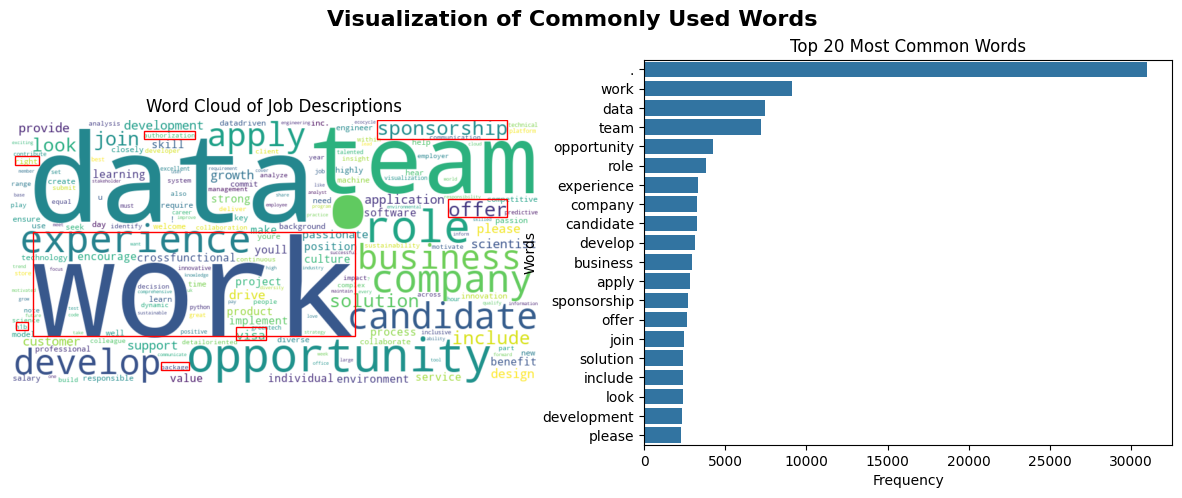

In [532]:
stop_words = set(stopwords.words('english'))
df['processed_description'] = df['processed_description'].apply(lambda text: ' '.join([word for word in word_tokenize(text) if word not in stop_words]))
visualize_words(df['processed_description'], 'Visualization of Commonly Used Words')


To refine the job description analysis, adjectives (e.g., "amazing," "dynamic") and other commonly seen but unnecessary words should be removed. These words often add little value to the core meaning and can skew the results of word frequency analysis. By eliminating such words, the analysis can focus on the more meaningful and relevant terms, providing clearer insights into the essential keywords used in job descriptions.

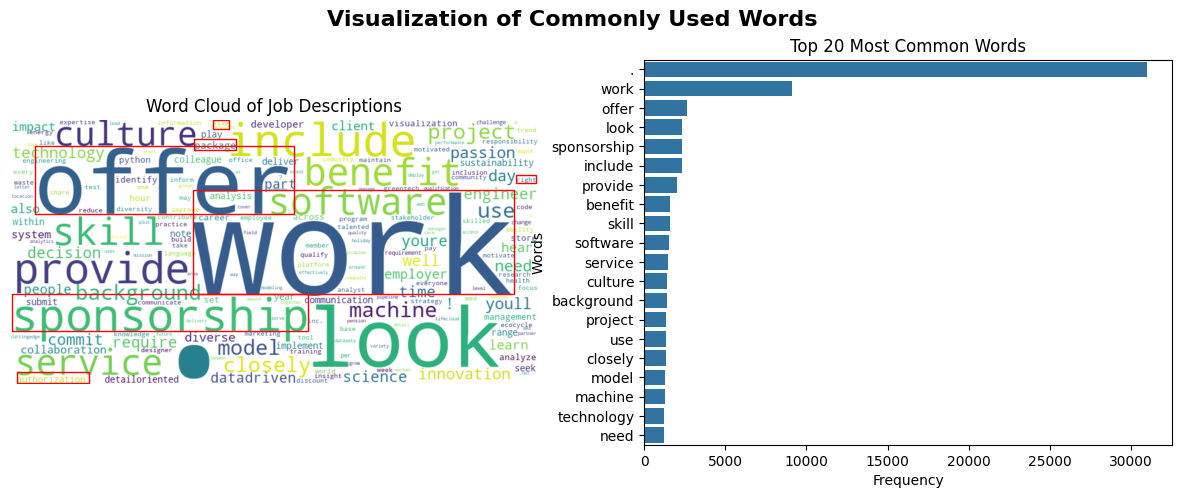

In [533]:

custom_stopwords = [
    "job", "position", "role", "team", "company", "candidate", "candidates", "applicant", 
    "hiring", "opportunity", "join", "apply",  "skills", "experience", "passionate",
    "environment", "responsibilities", "tasks", "benefits", "qualifications", 
    "including",  "preferred", "working", "please", "learning", "scientist",
    "highly", "welcome", "successful", "individuals", "exciting", "customer", "design", "product",
    "professional", "solutions", "drive", "growth", "business", "development", 
    "organization", "value", "process", "support", "using", "help", "create", "looking",  "opportunities", "teams", "encourage",
    "ensure", "must", "make", "meet", "collaborate", "applications", "technical", "data", "including", "develop", "solution", "application",
]
stop_words.update(custom_stopwords)
df['processed_description'] = df['processed_description'].apply(lambda text: ' '.join([word for word in word_tokenize(text) if word not in stop_words]))
df['processed_description'] = df['processed_description'].apply(
    lambda text: ' '.join([word for word, pos in pos_tag(word_tokenize(text)) if pos not in ['JJ', 'JJR', 'JJS']])
)


visualize_words(df['processed_description'], 'Visualization of Commonly Used Words')

After the removal of unnecessary words like adjectives and filler terms, words such as "visa," "work," and "offer" are seen prominently in the top 20 frequent words. Similarly, in the word cloud, terms like "visa", "authorization," and "package" stand out significantly in comparison to before the removal of the stop words. This suggests that visa sponsorship and work authorization are key topics in the analyzed job descriptions. This highlights the importance of these terms in setting expectations for candidates, particularly those requiring work authorization or visa-related support.

/var/folders/nl/83y8p4r54391lvfj9k76c8180000gn/T/ipykernel_64114/241293741.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('sponsorship_available')


138
45
0


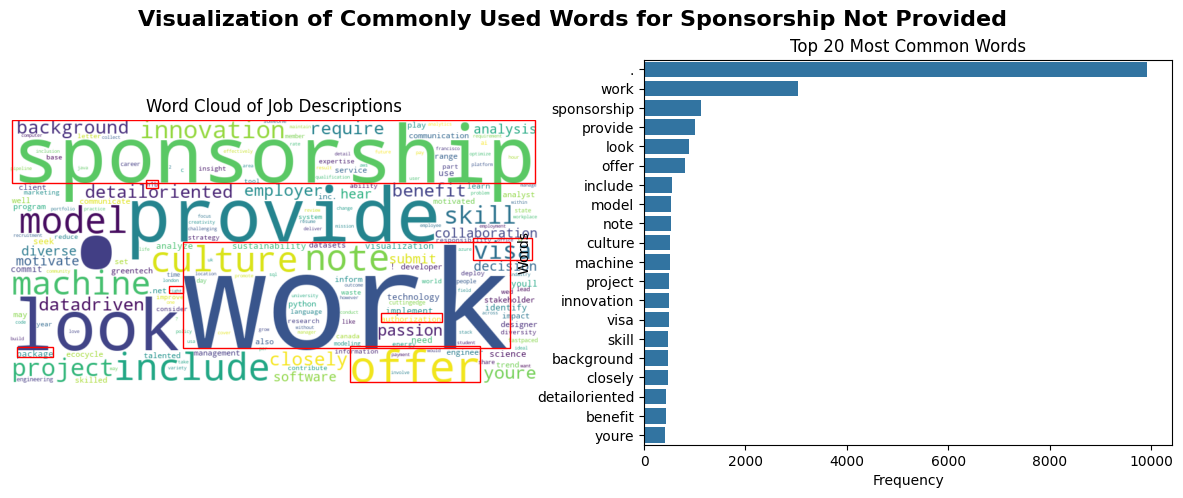

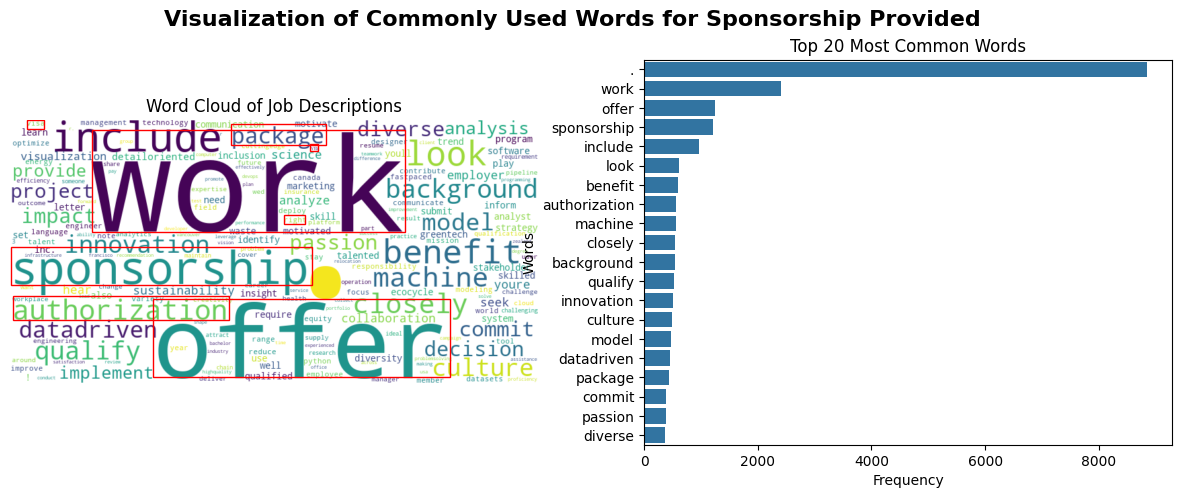

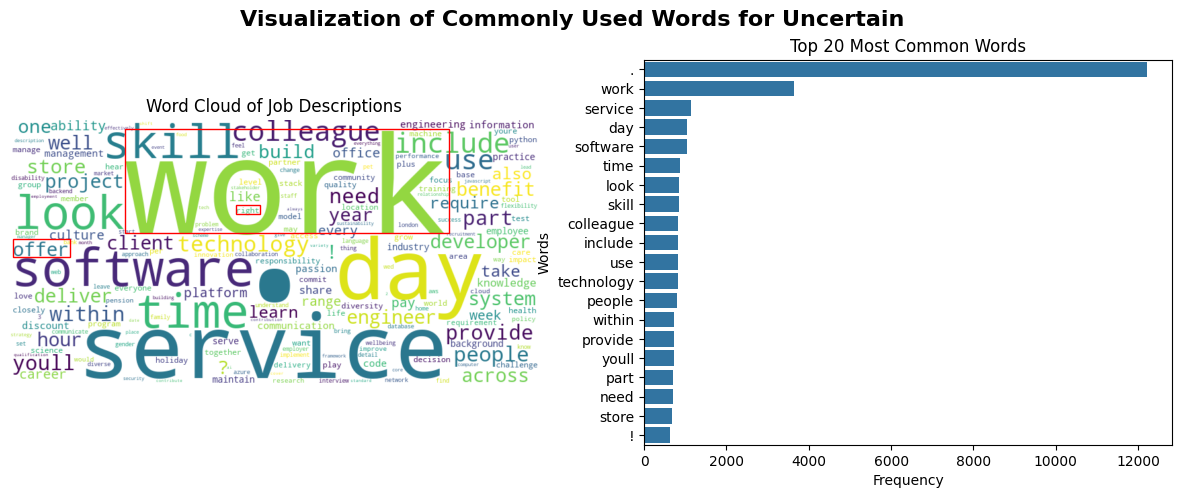

In [534]:
grouped = df.groupby('sponsorship_available')
word_frequency_by_class = {}

for sponsorship_class, group in grouped:
    visualize_words(group['processed_description'], 'Visualization of Commonly Used Words for '+sponsorship_class)
    group['word_count'] = group['processed_description'].str.lower().apply(lambda x: x.split().count('h1b'))

    # Total count of the word across all rows
    total_count = group['word_count'].sum()
    print(total_count)

Word clouds were generated for each sponsorship category to visually analyze the prominent words in job descriptions. Interestingly, words explicitly related to sponsorship—such as "visa," "sponsor," "authorized," or "eligibility"—appear distinctly in both the "Sponsorship Provided" and "Sponsorship Not Provided" categories. This highlights that these terms are actively used to clarify the sponsorship status in these job postings.

However, the "Uncertain" category paints a different picture. Words explicitly tied to sponsorship are notably absent, indicating a lack of clarity or direct reference to sponsorship availability. Instead, generic terms like "work," "right," and "offer" are observed. While these words may loosely relate to employment logistics, their vagueness suggests that sponsorship is likely not provided in these cases, or at the very least, not explicitly mentioned. This absence further supports the interpretation that uncertainty in job descriptions often corresponds to a lack of sponsorship availability or transparency.